In [2]:
import boto3
import pandas as pd
import numpy as np
import io
import sys
import os
import seaborn as sns
import seaborn as sns
from matplotlib import pyplot
import pymc3 as pm
import matplotlib.pyplot as plt


from sklearn import ensemble
from sklearn import linear_model
#from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# local libraries
sys.path.append(os.path.abspath(os.path.join(sys.path[0], '..', 'src', 'lib')))
import athena_connect
import market_maker_training

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = None
%matplotlib inline

%load_ext autoreload
%autoreload 2

/Users/puter/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def features(feature_minutes_list, trade_window_list=[18]):
    #TODO: move this config to simulation argument 
    coin_pair_dict = {'target':'ethusdt',
                  'alt':'btcusdt',
                  'through':'trxeth'}
    print(f"Coin feature configuration: {coin_pair_dict}")

    mm_training = market_maker_training.BinanceTraining(coin_pair_dict, feature_minutes_list, trade_window_list)
    try:
        mm_training.set_training_data()
    except Exception as e:
        print(f"Failed setting training data: {e}")
        return
    return mm_training.training_df, mm_training.feature_column_list, mm_training.target_column_list

feature_minutes_list = [1]
features_df, feature_col, target_col_list = features(feature_minutes_list)
features_df.tail(20)

Coin feature configuration: {'target': 'ethusdt', 'alt': 'btcusdt', 'through': 'trxeth'}
(122574, 120)
(122573, 120)


,ethusdt_trade_datetime,ethusdt_trade_date,ethusdt_trade_minute,trade_day_of_week,trade_hour,ethusdt_bid_ask_spread,ethusdt_bid_ask_average_price,ethusdt_bids_cum_5000_weighted_avg,ethusdt_bids_cum_10000_weighted_avg,ethusdt_bids_cum_20000_weighted_avg,ethusdt_bids_cum_50000_weighted_avg,ethusdt_bids_cum_100000_weighted_avg,ethusdt_bids_cum_200000_weighted_avg,ethusdt_bids_cum_5000_weighted_std,ethusdt_bids_cum_10000_weighted_std,ethusdt_bids_cum_20000_weighted_std,ethusdt_bids_cum_50000_weighted_std,ethusdt_bids_cum_100000_weighted_std,ethusdt_bids_cum_200000_weighted_std,ethusdt_asks_cum_5000_weighted_avg,ethusdt_asks_cum_10000_weighted_avg,ethusdt_asks_cum_20000_weighted_avg,ethusdt_asks_cum_50000_weighted_avg,ethusdt_asks_cum_100000_weighted_avg,ethusdt_asks_cum_200000_weighted_avg,ethusdt_asks_cum_5000_weighted_std,ethusdt_asks_cum_10000_weighted_std,ethusdt_asks_cum_20000_weighted_std,ethusdt_asks_cum_50000_weighted_std,ethusdt_asks_cum_100000_weighted_std,ethusdt_asks_cum_200000_weighted_std,btcusdt_bid_ask_spread,btcusdt_bid_ask_average_price,btcusdt_bids_cum_5000_weighted_avg,btcusdt_bids_cum_10000_weighted_avg,btcusdt_bids_cum_20000_weighted_avg,btcusdt_bids_cum_50000_weighted_avg,btcusdt_bids_cum_100000_weighted_avg,btcusdt_bids_cum_200000_weighted_avg,btcusdt_bids_cum_5000_weighted_std,btcusdt_bids_cum_10000_weighted_std,btcusdt_bids_cum_20000_weighted_std,btcusdt_bids_cum_50000_weighted_std,btcusdt_bids_cum_100000_weighted_std,btcusdt_bids_cum_200000_weighted_std,btcusdt_asks_cum_5000_weighted_avg,btcusdt_asks_cum_10000_weighted_avg,btcusdt_asks_cum_20000_weighted_avg,btcusdt_asks_cum_50000_weighted_avg,btcusdt_asks_cum_100000_weighted_avg,...,trxeth_bids_cum_200000_weighted_std,trxeth_asks_cum_5000_weighted_avg,trxeth_asks_cum_10000_weighted_avg,trxeth_asks_cum_20000_weighted_avg,trxeth_asks_cum_50000_weighted_avg,trxeth_asks_cum_100000_weighted_avg,trxeth_asks_cum_200000_weighted_avg,trxeth_asks_cum_5000_weighted_std,trxeth_asks_cum_10000_weighted_std,trxeth_asks_cum_20000_weighted_std,trxeth_asks_cum_50000_weighted_std,trxeth_asks_cum_100000_weighted_std,trxeth_asks_cum_200000_weighted_std,avg_5_btcusdt_bid_ask_average_price_interaction,avg_10_btcusdt_bid_ask_average_price_interaction,avg_20_btcusdt_bid_ask_average_price_interaction,prev_1_ethusdt_bid_ask_average_price_perc_chg,prev_1_ethusdt_bid_ask_average_price_rate_chg,prev_1_ethusdt_bids_cum_5000_weighted_avg_perc_chg,prev_1_ethusdt_bids_cum_50000_weighted_avg_perc_chg,prev_1_ethusdt_bids_cum_100000_weighted_avg_perc_chg,prev_1_ethusdt_bids_cum_200000_weighted_avg_perc_chg,prev_1_ethusdt_asks_cum_5000_weighted_avg_perc_chg,prev_1_ethusdt_asks_cum_50000_weighted_avg_perc_chg,prev_1_ethusdt_asks_cum_100000_weighted_avg_perc_chg,prev_1_ethusdt_asks_cum_200000_weighted_avg_perc_chg,prev_ethusdt_1_askbid_cum_5000_weighted_avg_perc_chg,prev_1_btcusdt_bid_ask_average_price_perc_chg,prev_1_btcusdt_bid_ask_average_price_rate_chg,prev_1_btcusdt_bids_cum_5000_weighted_avg_perc_chg,prev_1_btcusdt_bids_cum_50000_weighted_avg_perc_chg,prev_1_btcusdt_bids_cum_100000_weighted_avg_perc_chg,prev_1_btcusdt_bids_cum_200000_weighted_avg_perc_chg,prev_1_btcusdt_asks_cum_5000_weighted_avg_perc_chg,prev_1_btcusdt_asks_cum_50000_weighted_avg_perc_chg,prev_1_btcusdt_asks_cum_100000_weighted_avg_perc_chg,prev_1_btcusdt_asks_cum_200000_weighted_avg_perc_chg,prev_btcusdt_1_askbid_cum_5000_weighted_avg_perc_chg,prev_1_trxeth_bid_ask_average_price_perc_chg,prev_1_trxeth_bid_ask_average_price_rate_chg,prev_1_trxeth_bids_cum_5000_weighted_avg_perc_chg,prev_1_trxeth_bids_cum_50000_weighted_avg_perc_chg,prev_1_trxeth_bids_cum_100000_weighted_avg_perc_chg,prev_1_trxeth_bids_cum_200000_weighted_avg_perc_chg,prev_1_trxeth_asks_cum_5000_weighted_avg_perc_chg,prev_1_trxeth_asks_cum_50000_weighted_avg_perc_chg,prev_1_trxeth_asks_cum_100000_weighted_avg_perc_chg,prev_1_trxeth_asks_cum_200000_weighted_avg_perc_chg,prev_trxeth_1_askbid_cum_5000_weighted_avg_perc_chg,futr_18_askbid_cum_5000_weighted_

In [4]:
feature_col_base = ['trade_day_of_week',
 'trade_hour',
 'ethusdt_bid_ask_spread',
 'ethusdt_bids_cum_20000_weighted_std',
 'ethusdt_bids_cum_100000_weighted_std',
 'ethusdt_bids_cum_200000_weighted_std',
 'ethusdt_asks_cum_20000_weighted_std',
 'ethusdt_asks_cum_100000_weighted_std',
 'ethusdt_asks_cum_200000_weighted_std',
 'btcusdt_bid_ask_spread',
 'btcusdt_bids_cum_20000_weighted_std',
 'btcusdt_bids_cum_100000_weighted_std',
 'btcusdt_bids_cum_200000_weighted_std',
 'btcusdt_asks_cum_20000_weighted_std',
 'btcusdt_asks_cum_100000_weighted_std',
 'btcusdt_asks_cum_200000_weighted_std',
 'avg_5_btcusdt_bid_ask_average_price_interaction',
 'avg_10_btcusdt_bid_ask_average_price_interaction',
 'avg_20_btcusdt_bid_ask_average_price_interaction',
 'trxeth_bid_ask_spread',
 'trxeth_bids_cum_20000_weighted_std',
 'trxeth_bids_cum_100000_weighted_std',
 'trxeth_bids_cum_200000_weighted_std',
 'trxeth_asks_cum_20000_weighted_std',
 'trxeth_asks_cum_100000_weighted_std',
 'trxeth_asks_cum_200000_weighted_std',]

In [4]:
with pm.Model() as model:
    k_=pm.Uniform('k',-1,1)
    tau_=pm.Gamma('tau',mu=1,sd=1)
    obs=pm.AR1('observed',k=k_,tau_e=tau_,observed=features_df[feature_col])
    trace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, k]
Sampling 4 chains: 100%|██████████| 4000/4000 [14:40<00:00,  2.70s/draws]
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9531829194998535, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9601752344738316, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin st

         mean        sd  mc_error   hpd_2.5  hpd_97.5     n_eff          Rhat
k    0.514977  0.310453  0.031042  0.025706  0.932685       NaN  4.006740e+00
tau  0.925373  0.556538  0.055654  0.379059  1.797852  2.002002  1.415281e+06


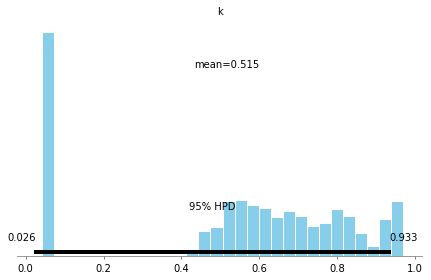

In [5]:
pm.plot_posterior(trace,'k')
print(pm.summary(trace))

In [6]:
pm

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']